Este proyecto se ha logrado con la ayuda de este tutorial para [LSTM Neural Network](https://www.codificandobits.com/blog/tutorial-prediccion-de-acciones-en-la-bolsa-redes-lstm/)

# Desarrollo de una Red Neuronal LSTM para la prediccion de valores de acciones

#### Carga librerias necesarias

In [ ]:
# Manipulacion de archivos
from google.colab import files

# Manipulacion de datos
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler  # normalizacion de los datos

# Visualizacion de datos
import matplotlib.pyplot as plt

# Modelos de aprendizaje
from keras.models import Sequential
from keras.layers import LSTM, Dense

#### Carga el dataset para trabajar

In [ ]:
files.upload()

Saving AAPL_2006-01-01_to_2018-01-01.csv to AAPL_2006-01-01_to_2018-01-01.csv


{'AAPL_2006-01-01_to_2018-01-01.csv': b'Date,Open,High,Low,Close,Volume,Name\r\n2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL\r\n2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL\r\n2006-01-05,10.69,10.7,10.54,10.63,112396081,AAPL\r\n2006-01-06,10.75,10.96,10.65,10.9,176139334,AAPL\r\n2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL\r\n2006-01-10,10.89,11.7,10.83,11.55,570088246,AAPL\r\n2006-01-11,11.98,12.11,11.8,11.99,373548882,AAPL\r\n2006-01-12,12.14,12.34,11.95,12.04,320201966,AAPL\r\n2006-01-13,12.14,12.29,12.09,12.23,194153393,AAPL\r\n2006-01-17,12.24,12.34,11.98,12.1,209215265,AAPL\r\n2006-01-18,11.87,12.01,11.69,11.78,303279501,AAPL\r\n2006-01-19,11.61,11.67,11.25,11.29,424100026,AAPL\r\n2006-01-20,11.33,11.43,10.83,10.87,284634847,AAPL\r\n2006-01-23,10.87,11.37,10.86,11.1,264942587,AAPL\r\n2006-01-24,11.25,11.35,10.82,10.86,285661873,AAPL\r\n2006-01-25,11.06,11.07,10.46,10.6,319019939,AAPL\r\n2006-01-26,10.65,10.78,10.28,10.33,295599087,AAPL\r\n2006-01-27,10.42,10.51,10.

#### Funciones auxiliares

In [ ]:
def plot_prediccion(datos_reales, datos_predichos):
    """
    Grafica la evolución de los datos reales y los datos predichos.

    Args:
        datos_reales (list): Lista de valores reales.
        datos_predichos (list): Lista de valores predichos.
    """

    # Graficar los datos reales en azul y los datos predichos en rojo
    diferencia_entre_bloques = len(datos_reales)-len(datos_predichos)
    plt.plot(datos_reales[diferencia_entre_bloques:], color='blue', label='Datos Reales')
    plt.plot(datos_predichos, color='red', label='Datos Predichos')

    # Agregar etiquetas y leyenda
    plt.ylim(1.1 * np.min(datos_predichos)/2, 1.1 * np.max(datos_predichos))
    plt.xlabel('Tiempo')
    plt.ylabel('Valor de la acción')
    plt.legend()

    # Mostrar el gráfico
    plt.show()


#### Lectura de los datos

In [ ]:
dataset = pd.read_csv('AAPL_2006-01-01_to_2018-01-01.csv', index_col='Date', parse_dates=['Date'] )
print(dataset.shape)
dataset.head()

(3019, 6)


,Open,High,Low,Close,Volume,Name
Date,,,,,,
2006-01-03,10.34,10.68,10.32,10.68,201853036,AAPL
2006-01-04,10.73,10.85,10.64,10.71,155225609,AAPL
2006-01-05,10.69,10.70,10.54,10.63,112396081,AAPL
2006-01-06,10.75,10.96,10.65,10.90,176139334,AAPL
2006-01-09,10.96,11.03,10.82,10.86,168861224,AAPL


In [ ]:
dataset.tail()

,Open,High,Low,Close,Volume,Name
Date,,,,,,
2017-12-22,174.68,175.42,174.50,175.01,16349444,AAPL
2017-12-26,170.80,171.47,169.68,170.57,33185536,AAPL
2017-12-27,170.10,170.78,169.71,170.60,21498213,AAPL
2017-12-28,171.00,171.85,170.48,171.08,16480187,AAPL
2017-12-29,170.52,170.59,169.22,169.23,25999922,AAPL


El dataset comprende una secuencia temporal, los registros empiezan el 2006-03-01 y terminan el 2017-12-29. En total registras los valores de la accion de, aproximadamente, 12 años.

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    3019 non-null   float64
 1   High    3019 non-null   float64
 2   Low     3019 non-null   float64
 3   Close   3019 non-null   float64
 4   Volume  3019 non-null   int64  
 5   Name    3019 non-null   object 
dtypes: float64(4), int64(1), object(1)
memory usage: 165.1+ KB


No hay valores nulos ni valores faltantes.
El dataset cuenta con 5 columnas numericas (4 float y 1 int) y 1 columna de tipo categórica

In [ ]:
dataset.describe()

,Open,High,Low,Close,Volume
count,3019.000000,3019.000000,3019.000000,3019.000000,3.019000e+03
mean,64.673309,65.256833,64.033445,64.662892,1.311457e+08
std,44.524927,44.811772,44.230829,44.536448,1.018560e+08
min,7.390000,7.560000,7.170000,7.240000,1.147592e+07
25%,23.425000,23.805000,23.015000,23.420000,5.292889e+07
50%,57.860000,58.460000,57.320000,57.920000,1.066271e+08
75%,99.165000,100.275000,98.385000,99.480000,1.798977e+08
max,175.110000,177.200000,174.860000,176.420000,8.432640e+08


In [ ]:
dataset.describe(include=['O'])

,Name
count,3019
unique,1
top,AAPL
freq,3019


### Split de los datos

Dado que es una secuencia temporal, separo los datos del final para usarlos como datos de validacion.
Entonces, todos los registros hasta el año 2016, incluido, serán para el entrenamiento y el último año, 2017, será para hacer la validación.
Solamente se utilizará un valor de la acción en cada día, en este caso, el valor máximo, 'High'.

In [ ]:
set_entrenamiento = dataset.loc[:'2016','High']

Otra forma de escribir el comando para separarlo es  `dataset['High'][:'2016']`. En estos dos casos, el tipo de dato retornado es Serie.

En cambio, otra forma de extraer los datos para el entrenamiento es `dataset[:'2016'].iloc[:,1:2]` en este caso el tipo de dato es distinto, devuelve un Dataframe de una sola columna.

In [ ]:
set_validacion = dataset.loc['2017':,'High']  # de nuevo, otra forma es dataset['High']['2017'], o dataset['2017':].iloc[:,1:2]

#### Visualizacion de la separación

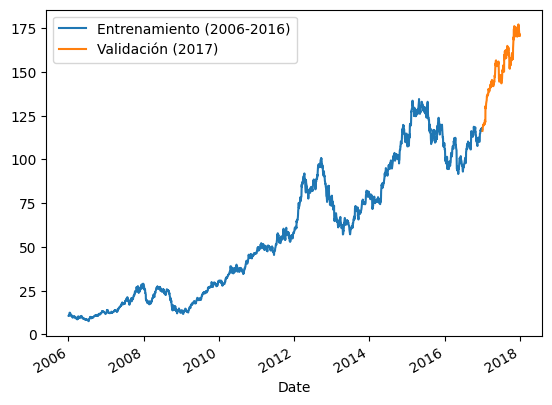

In [ ]:
set_entrenamiento.plot(legend=True)
set_validacion.plot(legend=True)

plt.legend(['Entrenamiento (2006-2016)', 'Validación (2017)'])
plt.show()

### Normalización de los datos

Se escalan los datos para evitar el conflicto que genera la secuencia creciente de datos. La función de costo daría mayor importancia a los valores más alto de la secuencia y afectaría negativamente el rendimiento del modelo.

Para las series temporales no se suele estandarizar los datos, en cambio, se los escala.

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
set_entrenamiento_escalado = sc.fit_transform(pd.DataFrame(set_entrenamiento))
set_entrenamiento_escalado.shape

(2768, 1)

In [ ]:
set_validacion_escalado = sc.transform(pd.DataFrame(set_validacion))

Para visualizar correctamente, se convierte los datasets escalados a dataframes con los indices originales para que Pandas grafique ambos en el mismo cuadro.

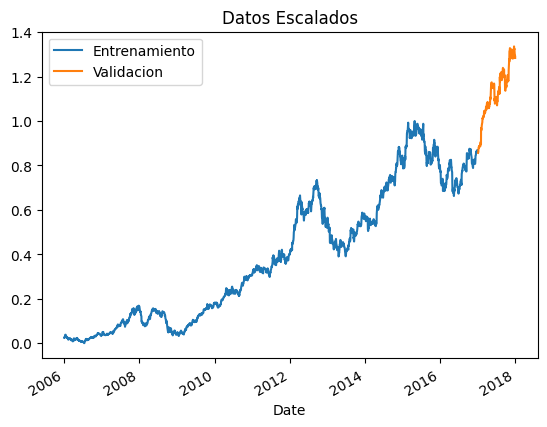

In [ ]:
# Convierte a dataframe
set_entrenamiento_escalado_df = pd.DataFrame(set_entrenamiento_escalado)
set_validacion_escalado_df = pd.DataFrame(set_validacion_escalado)

# Convierte los indices
set_entrenamiento_escalado_df.index = set_entrenamiento.index
set_validacion_escalado_df.index = set_validacion.index


set_entrenamiento_escalado_df[0].plot(legend=True)
set_validacion_escalado_df[0].plot(legend=True)

plt.legend(['Entrenamiento', 'Validacion'])
plt.title('Datos Escalados')
plt.show()

### Creacion y entrenamiento del modelo

#### Definicion del tamano de los datos para el modelo

Para el entrenamiento se tomarán bloques de datos consecutivos. Es decir, sera una secuencia de bloques de datos donde cada bloque se usara para predecir el dato inmediatamente siguiente.

Por ejemplo, si el primer bloque de entrenamiento comprende 60 datos, luego el primer valor de la secuencia de predicciones correspondera al valor numero 61 en el orden de la secuencia. Asi, hasta el final de la secuencia de entrenamiento. Quedando dos secuencias con un `length` de 60 unidades menor al del set original, es decir, el `length` del bloque.

In [ ]:
time_step = 60  # tamaño del bloque
m = len(set_entrenamiento_escalado) # limite de la iteracion
X_train = []
Y_train = []

for i in range(time_step, m):
  X_train.append(set_entrenamiento_escalado[i-time_step:i,0])

  # el dato inmediatamente siguiente al del bloque
  Y_train.append(set_entrenamiento_escalado[i,0])

print('Length de X_train:',len(X_train))

# Se devuelve el formato de dato anterior para seguir trabajando
X_train, Y_train = np.array(X_train), np.array(Y_train)

print('Dimension de X_train reconvertido a array:', X_train.shape)
print('Dimension de Y_train reconvertido a array:', Y_train.shape)

Length de X_train: 2708
Dimension de X_train reconvertido a array: (2708, 60)
Dimension de Y_train reconvertido a array: (2708,)


In [ ]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_train.shape

(2708, 60, 1)

#### Creacion del modelo

Se construye un modelo `Sequential` *'many-to-one'* comprendido por dos capas internas.

La primera es una red `LSTM`, especial para casos de secuencias larga de datos como este.

La segunda, la capa de salida, `Dense` que retorna una salida numerica directa sin aplicar una funcion de activacion, ideal para tareas de regresion como esta donde se busca predecir un valor numerico continuo.

In [ ]:
dim_entrada = (X_train.shape[1],1) # (timesteps, features)
dim_salida = 1
na = 50 # número de unidades (neuronas)

modelo = Sequential()

# Capa LSTM
modelo.add(LSTM(units=na, input_shape=dim_entrada))

# Capa de Salida (sin activación para regresión)
modelo.add(Dense(units=dim_salida))

# Compilacion
modelo.compile(optimizer='rmsprop', loss='mse')


Se utiliza en la compilacion el optimizador `rmsprop` para acelerar la convergencia.

La funcion de costo es el error cuadratico medio, `mse`.

#### Entrenamiento del modelo

In [ ]:
modelo.fit(X_train, Y_train, epochs=20, batch_size=32)

Epoch 1/20
85/85 [==============================] - 3s 17ms/step - loss: 0.0078
Epoch 2/20
85/85 [==============================] - 2s 20ms/step - loss: 0.0011
Epoch 3/20
85/85 [==============================] - 2s 26ms/step - loss: 7.8002e-04
Epoch 4/20
85/85 [==============================] - 2s 20ms/step - loss: 6.5632e-04
Epoch 5/20
85/85 [==============================] - 1s 16ms/step - loss: 5.2297e-04
Epoch 6/20
85/85 [==============================] - 1s 16ms/step - loss: 4.7475e-04
Epoch 7/20
85/85 [==============================] - 1s 16ms/step - loss: 4.1505e-04
Epoch 8/20
85/85 [==============================] - 1s 16ms/step - loss: 4.1444e-04
Epoch 9/20
85/85 [==============================] - 1s 17ms/step - loss: 3.6878e-04
Epoch 10/20
85/85 [==============================] - 2s 20ms/step - loss: 3.5694e-04
Epoch 11/20
85/85 [==============================] - 1s 16ms/step - loss: 3.2301e-04
Epoch 12/20
85/85 [==============================] - 1s 16ms/step - loss: 3.0837e-

### Prediccion

#### Definicion del tamano de los datos para la validacion

Primero hay que preparar el set de validacion con la misma estructura de bloques con la que se trabajo para el entrenamiento.

In [ ]:
X_test = []
for i in range (time_step, len(set_validacion_escalado)):
  X_test.append(set_validacion_escalado[i-time_step:i,0])

X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [ ]:
X_test.shape

(191, 60, 1)

#### Prediccion

In [ ]:
prediccion = modelo.predict(X_test)

6/6 [==============================] - 0s 5ms/step


Se invierte la normalizacion para obtener los valores predichos en la escala real de las acciones.

In [ ]:
prediccion = sc.inverse_transform(prediccion)

#### Visualizacion

Es importante notar que la prediccion se hace desde el primer valor despues del primer bloque. En el caso del ejemplo, es el dato de orden 61 en la secuencia.

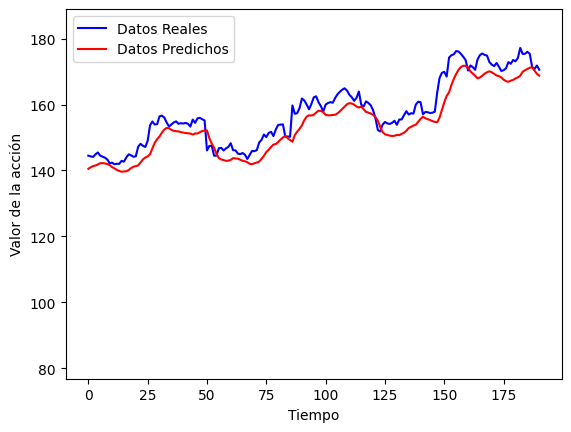

In [ ]:
plot_prediccion(set_validacion.values, prediccion)

### Analisis posterior

Se cargan los valores a un nuevo DataFrame ajustando el tamano del set de validacion al tamano de la prediccion, `len(prediccion)`

In [ ]:
set_validacion.shape

(251,)

In [ ]:
len(prediccion)

191

In [ ]:
res_set_validacion = set_validacion[-len(prediccion):]
res_set_validacion.index

DatetimeIndex(['2017-03-30', '2017-03-31', '2017-04-03', '2017-04-04',
               '2017-04-05', '2017-04-06', '2017-04-07', '2017-04-10',
               '2017-04-11', '2017-04-12',
               ...
               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22', '2017-12-26', '2017-12-27',
               '2017-12-28', '2017-12-29'],
              dtype='datetime64[ns]', name='Date', length=191, freq=None)

In [ ]:
res = pd.DataFrame({'High validacion':res_set_validacion,'High prediccion':prediccion[:,0]})
res.head()

,High validacion,High prediccion
Date,,
2017-03-30,144.50,140.483002
2017-03-31,144.27,140.992371
2017-04-03,144.12,141.318405
2017-04-04,144.89,141.507202
2017-04-05,145.46,141.825821


In [ ]:
res['Error'] = ((res['High validacion']-res['High prediccion'])/res['High validacion']) * 100
res.head()

,High validacion,High prediccion,Error
Date,,,
2017-03-30,144.50,140.483002,2.779930
2017-03-31,144.27,140.992371,2.271872
2017-04-03,144.12,141.318405,1.943932
2017-04-04,144.89,141.507202,2.334735
2017-04-05,145.46,141.825821,2.498404


Text(0, 0.5, 'Porcentaje')

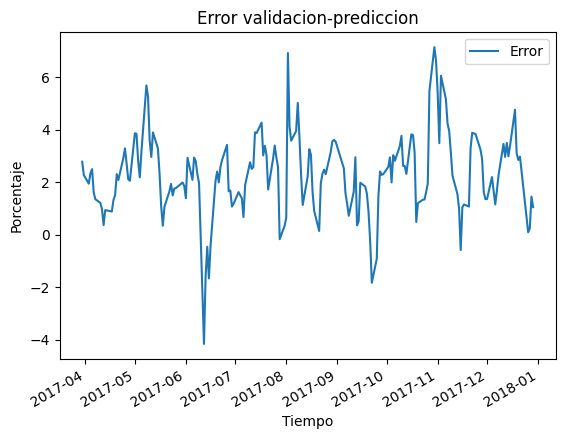

In [ ]:
res['Error'].plot(legend=True)

plt.title('Error validacion-prediccion')
plt.xlabel('Tiempo')
plt.ylabel('Porcentaje')

Se puede observar que el error no es mayor al 6% casi en la totalidad de los valores predichos.



In [ ]:
res[(res['Error']>6) | (res['Error']<-6)].sort_values('Error', ascending=False)

,High validacion,High prediccion,Error
Date,,,
2017-10-30,168.07,156.063126,7.143972
2017-08-02,159.75,148.696640,6.919161
2017-10-31,169.65,158.403610,6.629172
2017-11-03,174.26,163.704727,6.057198


Solamente hay 4 ocasiones en las que el error de prediccion supera el 6%, siendo 7.14% el maximo error.

<Axes: >

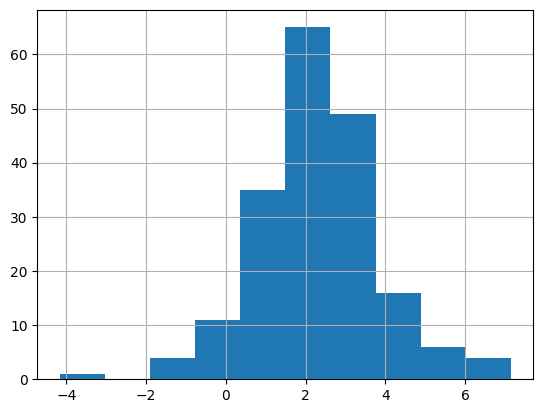

In [ ]:
res['Error'].hist()

El sesgo del error es positivo, lo que se traduce en que el modelo tiende a predecir los valores por debajo del valor real. En la gran mayoria de los casos el valor predicho se encuentra entre 1 a 3% por debajo del valor real.